In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from qini_curve import qini_df
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")

In [2]:
df["old_target"] = 1

df.loc[df["target_class"].isin([0, 2]), "old_target"] = 0

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

In [3]:
df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)

df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
2052,12,42.76,1,0,1,0,0,1,0,0,1,0,0.477596,0.002233,0.492098,0.028073,0.098630,0,0
9188,3,236.74,1,1,0,0,1,0,0,0,1,0,0.338212,0.149336,0.319221,0.193231,0.141542,1,1
6079,4,46.65,1,0,1,1,0,0,1,0,0,1,0.430861,0.026719,0.436040,0.106380,0.275457,2,0
9711,1,349.65,1,0,0,0,1,0,0,0,0,1,0.421712,0.128117,0.272425,0.177745,0.323655,1,1
11499,9,155.39,0,1,1,0,0,1,0,0,0,1,0.491633,0.014481,0.447632,0.046254,0.130083,0,0


In [ ]:
from catboost import CatBoostRegressor

df_train_1 = df_train.loc[df_train[treatment_col] == 1]
df_train_0 = df_train.loc[df_train[treatment_col] == 0]

t_learner_1 = CatBoostRegressor(random_state=1)
t_learner_0 = CatBoostRegressor(random_state=1)

t_learner_1.fit(df_train_1[feature_cols], df_train_1[target_col])
t_learner_0.fit(df_train_0[feature_cols], df_train_0[target_col])

Learning rate set to 0.052448
0:	learn: 0.3865408	total: 47.5ms	remaining: 47.5s
1:	learn: 0.3860784	total: 48.1ms	remaining: 24s
2:	learn: 0.3854618	total: 48.7ms	remaining: 16.2s
3:	learn: 0.3849481	total: 49.2ms	remaining: 12.2s
4:	learn: 0.3844271	total: 49.8ms	remaining: 9.9s
5:	learn: 0.3839711	total: 50.2ms	remaining: 8.32s
6:	learn: 0.3834851	total: 50.8ms	remaining: 7.2s
7:	learn: 0.3830849	total: 51.3ms	remaining: 6.36s
8:	learn: 0.3828307	total: 51.7ms	remaining: 5.69s
9:	learn: 0.3824592	total: 52.2ms	remaining: 5.16s
10:	learn: 0.3822407	total: 52.6ms	remaining: 4.73s
11:	learn: 0.3818523	total: 53.1ms	remaining: 4.37s
12:	learn: 0.3816849	total: 53.5ms	remaining: 4.07s
13:	learn: 0.3814596	total: 54.6ms	remaining: 3.84s
14:	learn: 0.3812139	total: 55.2ms	remaining: 3.63s
15:	learn: 0.3810259	total: 55.9ms	remaining: 3.43s
16:	learn: 0.3808480	total: 56.5ms	remaining: 3.27s
17:	learn: 0.3806293	total: 57ms	remaining: 3.11s
18:	learn: 0.3803986	total: 57.6ms	remaining: 2.97

array([21.29561168, 38.70229006,  5.29459491,  5.10795936,  6.25728171,
        4.12743953,  4.38769701,  3.75733424,  2.09414043,  2.70293595,
        6.27271512])

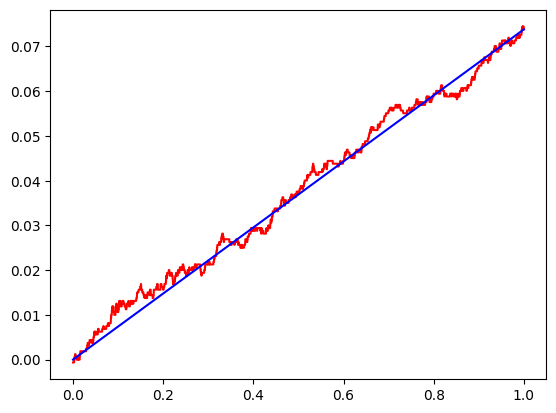

np.float64(2.1299000000000006)

In [6]:
df_test["yes_treatment"] = t_learner_1.predict(df_test[feature_cols])
df_test["no_treatment"] = t_learner_0.predict(df_test[feature_cols])

uplift_vals = df_test["yes_treatment"] - df_test["no_treatment"]
df_test["uplift_score"] = uplift_vals
qini_df(df_test)